# Model Building and Analysis, 2014 to 2023 Data

In [8]:
from google.colab import files
uploaded = files.upload()

Saving monthly cpi.csv to monthly cpi.csv


In [5]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [9]:
df = pd.read_csv('hdb-price-with-features-2014to2023.csv').iloc[:, 1:]
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,...,mall_count_within_1km,mall_list_within_1km,school_shortest_dist,school_shortest_dist_name,good_sch_count_within_1km,good_sch_list_within_1km,good_sch_score,good_sch_score_sap_gep,distance_to_cbd_km,matured
0,2023-03-01,BISHAN,5 ROOM,450,SIN MING AVE,19 TO 21,120.0,Improved,1989,65.833333,...,2,"['Thomson Plaza', 'Thomson V']",0.381927,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1
1,2022-11-01,BISHAN,5 ROOM,450,SIN MING AVE,01 TO 03,120.0,Improved,1989,66.166667,...,2,"['Thomson Plaza', 'Thomson V']",0.381927,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1
2,2022-10-01,BISHAN,5 ROOM,450,SIN MING AVE,04 TO 06,125.0,Improved,1989,66.250000,...,2,"['Thomson Plaza', 'Thomson V']",0.381927,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1
3,2022-09-01,BISHAN,EXECUTIVE,450,SIN MING AVE,22 TO 24,162.0,Maisonette,1989,66.333333,...,2,"['Thomson Plaza', 'Thomson V']",0.381927,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1
4,2022-09-01,BISHAN,5 ROOM,450,SIN MING AVE,16 TO 18,125.0,Improved,1989,66.333333,...,2,"['Thomson Plaza', 'Thomson V']",0.381927,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1


In [10]:
cpi = pd.read_csv('monthly cpi.csv')
cpi = cpi.set_index('Data Series')
cpi_data = pd.DataFrame(cpi.columns, columns=['month'])
cpi_data['CPI'] = pd.to_numeric(np.array(cpi.loc['All Items']))
cpi_data = cpi_data.iloc[1: , :]
cpi_data['month'] = pd.to_datetime(cpi_data['month'])

cpi_data.head()

<ipython-input-10-7f2467755fdf>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpi_data['month'] = pd.to_datetime(cpi_data['month'])


,month,CPI
1,2023-01-01,111.397
2,2022-12-01,111.186
3,2022-11-01,110.959
4,2022-10-01,109.893
5,2022-09-01,110.339


In [11]:
cpi_data.dtypes

month    datetime64[ns]
CPI             float64
dtype: object

In [12]:
df['month'] = pd.to_datetime(df['month'])
df = pd.merge(df, cpi_data, how = 'left')
df['adjusted_price'] = (df['resale_price'] / df['CPI'].fillna(100))*100
df['year'] = pd.DatetimeIndex(df['month']).year
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,...,school_shortest_dist_name,good_sch_count_within_1km,good_sch_list_within_1km,good_sch_score,good_sch_score_sap_gep,distance_to_cbd_km,matured,CPI,adjusted_price,year
0,2023-03-01,BISHAN,5 ROOM,450,SIN MING AVE,19 TO 21,120.0,Improved,1989,65.833333,...,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1,NaN,9.000000e+05,2023
1,2022-11-01,BISHAN,5 ROOM,450,SIN MING AVE,01 TO 03,120.0,Improved,1989,66.166667,...,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1,110.959,6.849377e+05,2022
2,2022-10-01,BISHAN,5 ROOM,450,SIN MING AVE,04 TO 06,125.0,Improved,1989,66.250000,...,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1,109.893,7.534602e+05,2022
3,2022-09-01,BISHAN,EXECUTIVE,450,SIN MING AVE,22 TO 24,162.0,Maisonette,1989,66.333333,...,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1,110.339,1.101152e+06,2022
4,2022-09-01,BISHAN,5 ROOM,450,SIN MING AVE,16 TO 18,125.0,Improved,1989,66.333333,...,Ai Tong School,1,['Ai Tong School'],1,1,8.14046,1,110.339,7.866665e+05,2022


In [13]:
df.isna().sum()

month                           0
town                            0
flat_type                       0
block                           0
street_name                     0
storey_range                    0
floor_area_sqm                  0
flat_model                      0
lease_commence_date             0
remaining_lease                 0
resale_price                    0
address                         0
latitude                        0
longitude                       0
shortest_dist_mrt_name          0
shortest_dist_mrt               0
mrt_count_within_1km            0
mrt_list_within_1km             0
shortest_dist_mall_name         0
shortest_dist_mall              0
mall_count_within_1km           0
mall_list_within_1km            0
school_shortest_dist            0
school_shortest_dist_name       0
good_sch_count_within_1km       0
good_sch_list_within_1km        0
good_sch_score                  0
good_sch_score_sap_gep          0
distance_to_cbd_km              0
matured       

In [14]:
df['CPI'].dropna()

1         110.959
2         109.893
3         110.339
4         110.339
5         106.547
           ...   
200004     99.342
200005     99.749
200006     99.749
200007     99.749
200008     99.484
Name: CPI, Length: 197602, dtype: float64

In [15]:
df.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price', 'address', 'latitude', 'longitude',
       'shortest_dist_mrt_name', 'shortest_dist_mrt', 'mrt_count_within_1km',
       'mrt_list_within_1km', 'shortest_dist_mall_name', 'shortest_dist_mall',
       'mall_count_within_1km', 'mall_list_within_1km', 'school_shortest_dist',
       'school_shortest_dist_name', 'good_sch_count_within_1km',
       'good_sch_list_within_1km', 'good_sch_score', 'good_sch_score_sap_gep',
       'distance_to_cbd_km', 'matured', 'CPI', 'adjusted_price', 'year'],
      dtype='object')

In [16]:
data = df.drop(['month','block', 'street_name', 'lease_commence_date',
                'resale_price','address', 'latitude', 'longitude',
                'shortest_dist_mrt_name', 'mrt_list_within_1km',
                'shortest_dist_mall_name','mall_list_within_1km',
                'school_shortest_dist_name', 'good_sch_list_within_1km', 'CPI'],
               axis = 1)
data.head()

,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,shortest_dist_mrt,mrt_count_within_1km,shortest_dist_mall,mall_count_within_1km,school_shortest_dist,good_sch_count_within_1km,good_sch_score,good_sch_score_sap_gep,distance_to_cbd_km,matured,adjusted_price,year
0,BISHAN,5 ROOM,19 TO 21,120.0,Improved,65.833333,0.516883,2,0.441609,2,0.381927,1,1,1,8.14046,1,9.000000e+05,2023
1,BISHAN,5 ROOM,01 TO 03,120.0,Improved,66.166667,0.516883,2,0.441609,2,0.381927,1,1,1,8.14046,1,6.849377e+05,2022
2,BISHAN,5 ROOM,04 TO 06,125.0,Improved,66.250000,0.516883,2,0.441609,2,0.381927,1,1,1,8.14046,1,7.534602e+05,2022
3,BISHAN,EXECUTIVE,22 TO 24,162.0,Maisonette,66.333333,0.516883,2,0.441609,2,0.381927,1,1,1,8.14046,1,1.101152e+06,2022
4,BISHAN,5 ROOM,16 TO 18,125.0,Improved,66.333333,0.516883,2,0.441609,2,0.381927,1,1,1,8.14046,1,7.866665e+05,2022


In [17]:
# label encoding for Storey Range
# The higher the storey_range, the higher the label encoding
le = LabelEncoder()
data = data.sort_values(by='storey_range')
data['storey_range'] = le.fit_transform(data['storey_range'])
data

,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,shortest_dist_mrt,mrt_count_within_1km,shortest_dist_mall,mall_count_within_1km,school_shortest_dist,good_sch_count_within_1km,good_sch_score,good_sch_score_sap_gep,distance_to_cbd_km,matured,adjusted_price,year
100004,BUKIT BATOK,EXECUTIVE,0,144.0,Apartment,76.166667,1.318182,0,1.427556,0,0.467040,0,0,0,11.926812,0,7.421448e+05,2020
93533,JURONG WEST,4 ROOM,0,112.0,Model A,62.666667,1.017612,0,0.718745,1,0.639279,0,0,0,16.702498,0,3.778844e+05,2021
93537,JURONG WEST,3 ROOM,0,94.0,Model A,63.750000,1.017612,0,0.718745,1,0.639279,0,0,0,16.702498,0,2.901944e+05,2020
93543,JURONG WEST,4 ROOM,0,108.0,Model A,66.583333,1.017612,0,0.718745,1,0.639279,0,0,0,16.702498,0,3.612586e+05,2017
93544,JURONG WEST,4 ROOM,0,103.0,Model A,66.750000,1.017612,0,0.718745,1,0.639279,0,0,0,16.702498,0,3.634014e+05,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119950,CENTRAL AREA,4 ROOM,16,94.0,Type S1,91.666667,0.264816,4,0.295279,4,0.284877,0,0,0,1.642962,0,1.003970e+06,2018
5976,CENTRAL AREA,4 ROOM,16,94.0,Type S1,87.333333,0.504834,2,0.125445,3,0.146162,0,0,0,1.803958,0,1.182969e+06,2022
119933,CENTRAL AREA,5 ROOM,16,105.0,Type S2,89.250000,0.264816,4,0.295279,4,0.284877,0,0,0,1.642962,0,1.246691e+06,2020
29806,CENTRAL AREA,4 ROOM,16,94.0,Type S1,93.000000,0.300452,4,0.267698,4,0.303171,0,0,0,1.610956,0,9.543888e+05,2016


In [18]:
data['flat_type'].value_counts()

4 ROOM              82859
3 ROOM              49448
5 ROOM              49399
EXECUTIVE           15318
2 ROOM               2815
1 ROOM                 90
MULTI-GENERATION       80
Name: flat_type, dtype: int64

In [19]:
# remove flat_types with less than 1000 instances
flat_types_counts = data['flat_type'].value_counts()
data = data[~data['flat_type'].isin(flat_types_counts[flat_types_counts < 1000].index)]
data['flat_type'].value_counts()

4 ROOM       82859
3 ROOM       49448
5 ROOM       49399
EXECUTIVE    15318
2 ROOM        2815
Name: flat_type, dtype: int64

 1 Room and Multi-Generation flats are removed.

In [20]:
# label encoding for Flat Type
data = data.sort_values(by='flat_type')
data


,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,shortest_dist_mrt,mrt_count_within_1km,shortest_dist_mall,mall_count_within_1km,school_shortest_dist,good_sch_count_within_1km,good_sch_score,good_sch_score_sap_gep,distance_to_cbd_km,matured,adjusted_price,year
40778,YISHUN,2 ROOM,4,47.0,Model A,94.500000,0.947941,1,0.084907,1,0.250462,0,0,0,14.509355,0,286720.734005,2022
1495,GEYLANG,2 ROOM,2,45.0,Improved,68.000000,0.369173,3,0.910387,1,0.209904,3,3,0,5.029309,1,259238.550297,2016
198934,BEDOK,2 ROOM,0,44.0,Improved,58.833333,0.759851,1,0.769452,3,0.329318,3,3,1,10.388744,1,210467.237267,2018
170150,PUNGGOL,2 ROOM,2,46.0,Model A,94.166667,1.613124,0,0.428531,2,0.330548,1,1,0,14.042931,0,255119.906356,2019
66653,BUKIT PANJANG,2 ROOM,6,46.0,Model A,93.000000,0.865073,1,0.724921,2,0.396354,0,0,0,15.080864,0,275759.055525,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108365,PUNGGOL,EXECUTIVE,3,128.0,Premium Apartment,85.750000,1.812429,0,0.523030,1,0.268043,1,1,0,13.898444,0,562161.943156,2017
108364,PUNGGOL,EXECUTIVE,3,128.0,Premium Apartment,85.333333,1.812429,0,0.523030,1,0.268043,1,1,0,13.898444,0,589569.160998,2017
108358,PUNGGOL,EXECUTIVE,3,128.0,Premium Apartment,82.333333,1.812429,0,0.523030,2,0.268043,1,1,0,13.898444,0,582269.157651,2020
77788,WOODLANDS,EXECUTIVE,1,131.0,Apartment,80.750000,1.116483,0,0.251374,2,0.459087,0,0,0,16.800225,0,479295.435710,2019


In [21]:
data['flat_type'] = le.fit_transform(data['flat_type'])
data

,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,shortest_dist_mrt,mrt_count_within_1km,shortest_dist_mall,mall_count_within_1km,school_shortest_dist,good_sch_count_within_1km,good_sch_score,good_sch_score_sap_gep,distance_to_cbd_km,matured,adjusted_price,year
40778,YISHUN,0,4,47.0,Model A,94.500000,0.947941,1,0.084907,1,0.250462,0,0,0,14.509355,0,286720.734005,2022
1495,GEYLANG,0,2,45.0,Improved,68.000000,0.369173,3,0.910387,1,0.209904,3,3,0,5.029309,1,259238.550297,2016
198934,BEDOK,0,0,44.0,Improved,58.833333,0.759851,1,0.769452,3,0.329318,3,3,1,10.388744,1,210467.237267,2018
170150,PUNGGOL,0,2,46.0,Model A,94.166667,1.613124,0,0.428531,2,0.330548,1,1,0,14.042931,0,255119.906356,2019
66653,BUKIT PANJANG,0,6,46.0,Model A,93.000000,0.865073,1,0.724921,2,0.396354,0,0,0,15.080864,0,275759.055525,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108365,PUNGGOL,4,3,128.0,Premium Apartment,85.750000,1.812429,0,0.523030,1,0.268043,1,1,0,13.898444,0,562161.943156,2017
108364,PUNGGOL,4,3,128.0,Premium Apartment,85.333333,1.812429,0,0.523030,1,0.268043,1,1,0,13.898444,0,589569.160998,2017
108358,PUNGGOL,4,3,128.0,Premium Apartment,82.333333,1.812429,0,0.523030,2,0.268043,1,1,0,13.898444,0,582269.157651,2020
77788,WOODLANDS,4,1,131.0,Apartment,80.750000,1.116483,0,0.251374,2,0.459087,0,0,0,16.800225,0,479295.435710,2019


In [22]:
data['flat_model'].value_counts()

Model A                   65104
Improved                  50117
New Generation            27797
Premium Apartment         21842
Simplified                 8546
Apartment                  7682
Standard                   5922
Maisonette                 5773
DBSS                       2943
Model A2                   2503
Type S1                     401
Model A-Maisonette          360
Adjoined flat               334
Type S2                     206
Terrace                     121
Premium Apartment Loft       96
2-room                       42
Improved-Maisonette          26
Premium Maisonette           17
3Gen                          7
Name: flat_model, dtype: int64

In [23]:
# Re-categorize flat models into broader categories
replace_values = {'Model A-Maisonette':'Maisonette', 'Improved-Maisonette':'Maisonette',
                 'Premium Maisonette':'Maisonette',}
data = data.replace({'flat_model': replace_values})
data['flat_model'].value_counts()

Model A                   65104
Improved                  50117
New Generation            27797
Premium Apartment         21842
Simplified                 8546
Apartment                  7682
Maisonette                 6176
Standard                   5922
DBSS                       2943
Model A2                   2503
Type S1                     401
Adjoined flat               334
Type S2                     206
Terrace                     121
Premium Apartment Loft       96
2-room                       42
3Gen                          7
Name: flat_model, dtype: int64

In [24]:
# remove flat models with less than 1000 instances
flat_model_counts = data['flat_model'].value_counts()
data = data[~data['flat_model'].isin(flat_model_counts[flat_model_counts < 1000].index)]
data['flat_model'].value_counts()

Model A              65104
Improved             50117
New Generation       27797
Premium Apartment    21842
Simplified            8546
Apartment             7682
Maisonette            6176
Standard              5922
DBSS                  2943
Model A2              2503
Name: flat_model, dtype: int64

In [25]:
data['town'].sort_values().unique()

array(['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
       'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG',
       'CLEMENTI', 'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST',
       'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'PUNGGOL',
       'QUEENSTOWN', 'SEMBAWANG', 'SENGKANG', 'SERANGOON', 'TAMPINES',
       'TOA PAYOH', 'WOODLANDS', 'YISHUN'], dtype=object)

In [26]:
data['flat_model'].sort_values().unique()

array(['Apartment', 'DBSS', 'Improved', 'Maisonette', 'Model A',
       'Model A2', 'New Generation', 'Premium Apartment', 'Simplified',
       'Standard'], dtype=object)

In [27]:
data = pd.get_dummies(data, columns = ['town','flat_model'],drop_first = True)
data.sort_index(inplace = True)
data.columns

Index(['flat_type', 'storey_range', 'floor_area_sqm', 'remaining_lease',
       'shortest_dist_mrt', 'mrt_count_within_1km', 'shortest_dist_mall',
       'mall_count_within_1km', 'school_shortest_dist',
       'good_sch_count_within_1km', 'good_sch_score', 'good_sch_score_sap_gep',
       'distance_to_cbd_km', 'matured', 'adjusted_price', 'year', 'town_BEDOK',
       'town_BISHAN', 'town_BUKIT BATOK', 'town_BUKIT MERAH',
       'town_BUKIT PANJANG', 'town_BUKIT TIMAH', 'town_CENTRAL AREA',
       'town_CHOA CHU KANG', 'town_CLEMENTI', 'town_GEYLANG', 'town_HOUGANG',
       'town_JURONG EAST', 'town_JURONG WEST', 'town_KALLANG/WHAMPOA',
       'town_MARINE PARADE', 'town_PASIR RIS', 'town_PUNGGOL',
       'town_QUEENSTOWN', 'town_SEMBAWANG', 'town_SENGKANG', 'town_SERANGOON',
       'town_TAMPINES', 'town_TOA PAYOH', 'town_WOODLANDS', 'town_YISHUN',
       'flat_model_DBSS', 'flat_model_Improved', 'flat_model_Maisonette',
       'flat_model_Model A', 'flat_model_Model A2',
       'flat_

In order to account for multicollinearity, we drop one of the dummy variables.

For the town dummies, Ang Mo Kio is dropped. For the flat_model dummies, Apartment is dropped.

### Check for Multicolinearity and VIF

In [28]:
data.dtypes

flat_type                         int64
storey_range                      int64
floor_area_sqm                  float64
remaining_lease                 float64
shortest_dist_mrt               float64
mrt_count_within_1km              int64
shortest_dist_mall              float64
mall_count_within_1km             int64
school_shortest_dist            float64
good_sch_count_within_1km         int64
good_sch_score                    int64
good_sch_score_sap_gep            int64
distance_to_cbd_km              float64
matured                           int64
adjusted_price                  float64
year                              int64
town_BEDOK                        uint8
town_BISHAN                       uint8
town_BUKIT BATOK                  uint8
town_BUKIT MERAH                  uint8
town_BUKIT PANJANG                uint8
town_BUKIT TIMAH                  uint8
town_CENTRAL AREA                 uint8
town_CHOA CHU KANG                uint8
town_CLEMENTI                     uint8


In [29]:
data['flat_type'] = data['flat_type'].astype("int64")
data['storey_range'] = data['storey_range'].astype("int64")

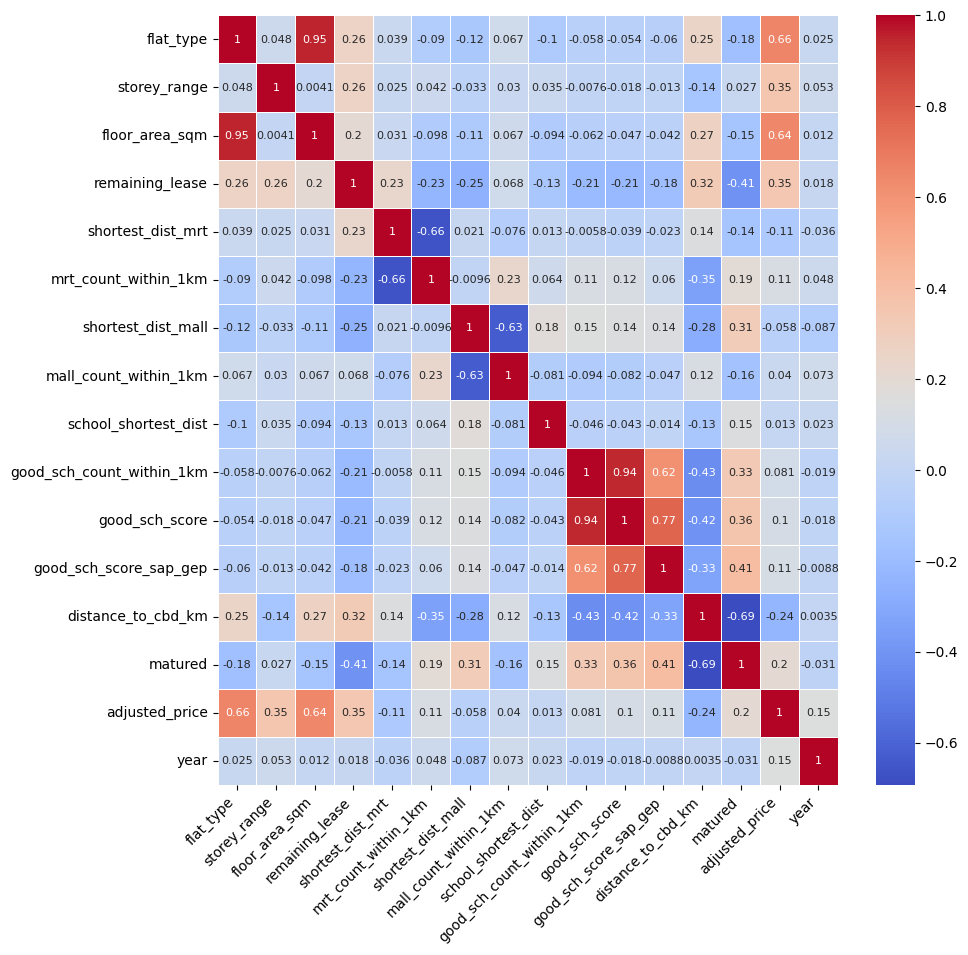

In [30]:
import seaborn as sns
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(data.select_dtypes(include=['int64','float64']).corr(), annot = True, fmt='.2g', 
      cmap = 'coolwarm', linewidth=0.5, annot_kws={"size": 8})

plt.xticks(rotation=45, ha='right')
fig.show()


High correlation (>0.6) between:

- flat_type and floor_area_sqm (0.95)
- shortest_dist_mrt and mrt_count_within_1km (-0.68)
- mall_count_within_1km and shortest_dist_mall (-0.7)
- good_sch_count_within_1km and good_sch_score (0.94)
- good_sch_score_sap_gep and good_sch_count_within_1km (0.6)
- good_sch_score_sap_ge and good_sch_score (0.76)
- distance_to_cbd_km and matured (-0.7)



If the largest VIF is greater than 10 then there is cause for concern (Bowerman & O’Connell, 1990; Myers, 1990)

If the average VIF is substantially greater than 1 then the regression may be biased (Bowerman & O’Connell, 1990).

Tolerance below 0.1 indicates a serious problem.

Tolerance below 0.2 indicates a potential problem (Menard, 1995).

In [31]:
# Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['tolerance'] = 1/vif.VIF
    vif['meanVIF'] = vif.VIF.mean()

    return(vif)

vif_df = calc_vif(data.drop('adjusted_price',axis=1).select_dtypes(include=['int64','float64']))
vif_df

,variables,VIF,tolerance,meanVIF
0,flat_type,74.657943,0.013394,39.704589
1,storey_range,2.713996,0.368460,39.704589
2,floor_area_sqm,202.753301,0.004932,39.704589
3,remaining_lease,52.272293,0.019131,39.704589
4,shortest_dist_mrt,7.986494,0.125211,39.704589
5,mrt_count_within_1km,4.877011,0.205044,39.704589
6,shortest_dist_mall,7.686246,0.130103,39.704589
7,mall_count_within_1km,4.600160,0.217384,39.704589
8,school_shortest_dist,3.991323,0.250543,39.704589
9,good_sch_count_within_1km,17.938042,0.055747,39.704589


- flat_type and floor_area_sqm (0.95)
- shortest_dist_mrt and mrt_count_within_1km (-0.68)
- mall_count_within_1km and shortest_dist_mall (-0.7)
- good_sch_count_within_1km and good_sch_score (0.94)
- good_sch_score_sap_gep and good_sch_count_within_1km (0.6)
- good_sch_score_sap_ge and good_sch_score (0.76)
- distance_to_cbd_km and matured (-0.7)

between flat_type and floor_area_sqm, we will drop flat_type as floor_area_sqm could have more potential for feature explanation as it is a continuous variable, while flat_type has been label encoded.

For the mrt, mall, sch features, we will choose to drop the features that measure the count within 1km first, for reasons being the shortest distance features being continuous.

Between distance to cbd and matured features, we will drop matured as distance to cbd is a continous variable as well.

Between good_sch_score_sap_gep and good_sch_score, we will just drop good_sch_score_sap_gep for the time being. Depending on the results of the good_sch_score feature results, we will decide if there is reason to run the models again but with good_sch_score_sap_gep instead.

year variable is dropped as well, as we have already accounted for resale price inflation using CPI values. This should account for majority of the impact that year has on resale prices, due to the fact that generally why prices increases over time is due to inflation. It is also dropped for model simplicity.


In [32]:
dropped_features = ['mrt_count_within_1km','mall_count_within_1km',
                    'matured','good_sch_count_within_1km','flat_type','good_sch_score_sap_gep',
                    'year']

calc_vif(data.drop(dropped_features,axis=1).
         drop('adjusted_price', axis = 1).
         select_dtypes(include=['int64','float64']))

,variables,VIF,tolerance,meanVIF
0,storey_range,2.695624,0.370972,9.164558
1,floor_area_sqm,17.054193,0.058637,9.164558
2,remaining_lease,27.554403,0.036292,9.164558
3,shortest_dist_mrt,4.376684,0.228483,9.164558
4,shortest_dist_mall,3.823081,0.261569,9.164558
5,school_shortest_dist,3.581022,0.279250,9.164558
6,good_sch_score,1.553520,0.643700,9.164558
7,distance_to_cbd_km,12.677937,0.078877,9.164558


We observe that remaining_lease and floor_area_sqm still has a very high VIF score, but we shall still keep these features as we feel they are important explainators of hdb resale price.

### Performance Measure

In [33]:
def model_performance(model, X_train, X_test, y_train, y_test):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print('R^2 score =', r2)
    print('MAE:', mae)
    print('RMSE', rmse)
    
    
    return(r2, mae, rmse)
    

### Train Test Split

In [34]:
df_1 = data.drop(columns = dropped_features)

# Split target variable from dataset
y= df_1['adjusted_price']
X = df_1.drop(columns='adjusted_price')


In [35]:
X

,storey_range,floor_area_sqm,remaining_lease,shortest_dist_mrt,shortest_dist_mall,school_shortest_dist,good_sch_score,distance_to_cbd_km,town_BEDOK,town_BISHAN,...,town_YISHUN,flat_model_DBSS,flat_model_Improved,flat_model_Maisonette,flat_model_Model A,flat_model_Model A2,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Simplified,flat_model_Standard
0,6,120.0,65.833333,0.516883,0.441609,0.381927,1,8.140460,0,1,...,0,0,1,0,0,0,0,0,0,0
1,0,120.0,66.166667,0.516883,0.441609,0.381927,1,8.140460,0,1,...,0,0,1,0,0,0,0,0,0,0
2,1,125.0,66.250000,0.516883,0.441609,0.381927,1,8.140460,0,1,...,0,0,1,0,0,0,0,0,0,0
3,7,162.0,66.333333,0.516883,0.441609,0.381927,1,8.140460,0,1,...,0,0,0,1,0,0,0,0,0,0
4,5,125.0,66.333333,0.516883,0.441609,0.381927,1,8.140460,0,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200004,1,42.0,58.000000,0.373753,1.289185,0.076720,0,5.957048,0,0,...,0,0,0,0,0,0,0,0,0,1
200005,1,89.0,71.000000,0.570874,0.534437,0.461900,0,15.250503,0,0,...,1,0,0,0,0,0,0,0,1,0
200006,2,56.0,58.000000,0.403762,1.310129,0.084406,0,5.941265,0,0,...,0,0,0,0,0,0,0,0,0,1
200007,2,56.0,56.000000,0.576045,1.214740,0.333109,0,6.049047,0,0,...,0,0,0,0,0,0,0,0,0,1


In [36]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=100)

In [37]:
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

158905 39727
158905 39727


### Feature Scaling

In [38]:
# Scale dataset
continuous_features = ['floor_area_sqm', 'remaining_lease','shortest_dist_mrt',
                 'shortest_dist_mall', 'school_shortest_dist', 'distance_to_cbd_km']

scaler = StandardScaler()
X_train_continuous = X_train[continuous_features]
X_train_continuous = scaler.fit_transform(X_train_continuous)

X_test_continuous = X_test[continuous_features]
X_test_continuous = scaler.transform(X_test_continuous)

# Replace original continuous features with scaled ones in X

X_train[continuous_features] = X_train_continuous
X_test[continuous_features] = X_test_continuous

In [39]:
X_train

,storey_range,floor_area_sqm,remaining_lease,shortest_dist_mrt,shortest_dist_mall,school_shortest_dist,good_sch_score,distance_to_cbd_km,town_BEDOK,town_BISHAN,...,town_YISHUN,flat_model_DBSS,flat_model_Improved,flat_model_Maisonette,flat_model_Model A,flat_model_Model A2,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Simplified,flat_model_Standard
116968,2,-2.214957,-1.184066,-0.632642,-0.222586,-0.553061,2,-0.522858,0,0,...,0,0,1,0,0,0,0,0,0,0
72556,4,-0.590237,1.391175,0.665540,-0.982259,0.576495,3,0.073936,0,0,...,0,1,0,0,0,0,0,0,0,0
27910,3,0.242953,0.573536,3.131035,-0.993384,-0.974827,0,0.576989,0,0,...,0,0,0,0,1,0,0,0,0,0
126856,4,-2.131638,1.539252,0.264277,0.754356,-1.188141,0,1.600352,0,0,...,0,0,0,0,1,0,0,0,0,0
188515,2,-2.173298,-0.540256,1.506377,0.557500,0.354602,0,-0.644793,1,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195747,2,-0.256961,0.412583,-1.567325,-0.458655,-0.835570,0,1.359698,0,0,...,0,0,0,0,1,0,0,0,0,0
66331,4,0.659547,1.610071,0.468027,-0.980611,-0.722021,0,0.370650,0,0,...,0,0,1,0,0,0,0,0,0,0
78484,1,0.326272,-1.074618,0.065337,0.907048,0.770984,0,0.948934,0,0,...,1,0,0,0,0,0,1,0,0,0
56761,2,0.534569,0.354641,-1.053107,-0.617396,0.854427,0,1.173042,0,0,...,0,0,1,0,0,0,0,0,0,0


In [40]:
X_test

,storey_range,floor_area_sqm,remaining_lease,shortest_dist_mrt,shortest_dist_mall,school_shortest_dist,good_sch_score,distance_to_cbd_km,town_BEDOK,town_BISHAN,...,town_YISHUN,flat_model_DBSS,flat_model_Improved,flat_model_Maisonette,flat_model_Model A,flat_model_Model A2,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Simplified,flat_model_Standard
26286,3,-1.215130,-1.164752,0.153169,0.552821,0.385577,0,-0.551152,0,0,...,0,0,0,0,0,0,1,0,0,0
21273,0,-1.256789,-0.662580,-0.457904,-0.374155,-0.665076,0,1.005088,0,0,...,0,0,0,0,0,0,1,0,0,0
33288,8,0.951164,0.419022,0.869671,2.384209,-0.285845,2,-1.525495,0,0,...,0,0,1,0,0,0,0,0,0,0
193933,2,-0.131983,0.728051,-1.163471,-1.280342,-0.078612,0,1.367636,0,0,...,0,0,0,0,0,0,0,1,0,0
197896,2,2.075970,0.341764,1.901276,0.333362,1.214757,0,0.480328,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144298,3,-1.340108,-1.699114,2.007057,-0.454375,-0.511751,2,-1.237034,0,0,...,0,0,1,0,0,0,0,0,0,0
93296,0,0.992823,-0.199036,0.031034,-0.829880,-0.891813,0,1.434512,0,0,...,0,0,1,0,0,0,0,0,0,0
158135,2,2.450906,0.251631,-0.109967,0.635714,-0.033728,2,-0.474920,0,0,...,0,0,0,0,0,0,0,0,0,0
138335,1,-1.256789,-0.527380,-1.324749,-0.735542,-0.648508,0,0.897474,0,0,...,1,0,0,0,0,0,1,0,0,0


## Model Building

We have shortlisted the following models to understand the drivers of HDB resale prices:
1. Linear Regression
2. Random Forest (bootstrap method)
3. XGBoost (boosting method)

Linear regression is shortlisted as it provides a useful way to interpret the respective impacts that each feature has on the hdb resale price. We will be able to infer directionality of the impacts as well.

We want to also compare the performances of ensemble methods, which are non-parametric in nature. Specifically, we shortlisted one bagging (bootstrap aggregating) method, which will be Random Forest, and one boosting method, which will be XGBoost. From this, we will compare the performances between the models and investigate feature importance.

#### 1. Linear Regression

In [41]:
lr = LinearRegression()
lin_reg_r2, lin_reg_mae, lin_reg_rmse = model_performance(lr, X_train, X_test, y_train, y_test)

R^2 score = 0.8475294726936848
MAE: 46014.12783996888
RMSE 58330.22708114213


Let's plot the coefficients and observe their respective impacts on hdb resale price

In [42]:
lr_importance = pd.DataFrame(list(zip(X_train.columns, lr.coef_)), columns =['Features', 'Coeff'])
lr_importance.sort_values(by = 'Coeff', ascending = False)

,Features,Coeff
22,town_MARINE PARADE,184598.985204
13,town_BUKIT TIMAH,177927.067989
1,floor_area_sqm,101275.095282
33,flat_model_DBSS,97461.877256
9,town_BISHAN,73998.175203
2,remaining_lease,62288.875928
25,town_QUEENSTOWN,57069.082992
35,flat_model_Maisonette,37990.848099
11,town_BUKIT MERAH,33416.960139
16,town_CLEMENTI,32464.262624


Let's also plot the OLS regression results, to look at the significance of the features.

In [43]:
X_constant = sm.add_constant(X_train)
lr_ols = sm.OLS(y_train,X_constant).fit()
print(lr_ols.summary())

                            OLS Regression Results                            
Dep. Variable:         adjusted_price   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                 2.127e+04
Date:                Sat, 01 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:57:22   Log-Likelihood:            -1.9692e+06
No. Observations:              158905   AIC:                         3.938e+06
Df Residuals:                  158862   BIC:                         3.939e+06
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [44]:
lr_importance['Coeff_ABS'] = np.abs(lr_importance['Coeff'])
lr_importance = lr_importance.sort_values('Coeff_ABS', ascending=False).reset_index(drop= True)
lr_importance['color'] = lr_importance['Coeff'].apply(lambda x: '#66ff8c' if x>0 else '#ff8c66')
lr_importance

,Features,Coeff,Coeff_ABS,color
0,town_MARINE PARADE,184598.985204,184598.985204,#66ff8c
1,town_BUKIT TIMAH,177927.067989,177927.067989,#66ff8c
2,floor_area_sqm,101275.095282,101275.095282,#66ff8c
3,flat_model_DBSS,97461.877256,97461.877256,#66ff8c
4,town_CHOA CHU KANG,-92415.923257,92415.923257,#ff8c66
5,town_SENGKANG,-87997.299674,87997.299674,#ff8c66
6,town_SEMBAWANG,-82501.492067,82501.492067,#ff8c66
7,town_BISHAN,73998.175203,73998.175203,#66ff8c
8,town_WOODLANDS,-66496.554465,66496.554465,#ff8c66
9,remaining_lease,62288.875928,62288.875928,#66ff8c


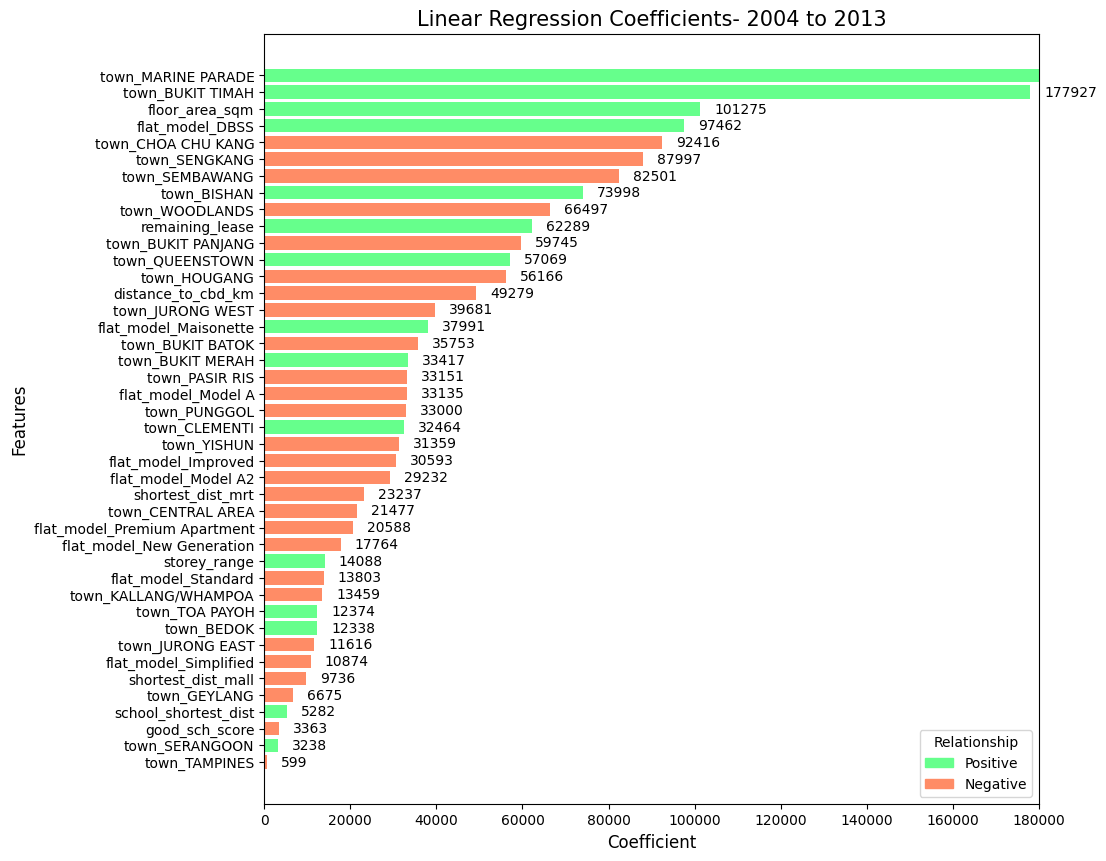

In [45]:
fig, ax = plt.subplots(figsize=(10,10))
graph = ax.barh(lr_importance['Features'], lr_importance['Coeff_ABS'],
                color=lr_importance['color'])


colors = {'Positive':'#66ff8c', 'Negative':'#ff8c66'}       
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels, title='Relationship',loc='lower right', fontsize ='10')

plt.title('Linear Regression Coefficients- 2004 to 2013', size = 15)
plt.ylabel('Features', size = 12)
plt.xlabel('Coefficient', size = 12)
ax.bar_label(graph, fmt='%.0f', padding =10)
ax.set_xlim(right=180000) 
ax.invert_yaxis()

plt.show()

#### 2. Random Forest 

Computing the baseline model

In [46]:
rf = RandomForestRegressor()
rf_r2, rf_mae, rf_rmse = model_performance(rf, X_train, X_test, y_train, y_test)

R^2 score = 0.9655131628285887
MAE: 19883.520975763313
RMSE 27741.337710456122


Training a baseline random forest model takes about 6-7 minutes.

In [47]:
rf_importance = pd.DataFrame(list(zip(rf.feature_names_in_, rf.feature_importances_)), columns =['Features', 'Coeff'])
rf_importance = rf_importance.sort_values(by = 'Coeff', ascending = False).reset_index(drop =True)
rf_importance

,Features,Coeff
0,floor_area_sqm,0.492281
1,distance_to_cbd_km,0.244442
2,remaining_lease,0.114635
3,storey_range,0.041548
4,shortest_dist_mrt,0.026711
5,shortest_dist_mall,0.019245
6,school_shortest_dist,0.009675
7,flat_model_DBSS,0.008408
8,flat_model_Model A,0.005823
9,town_BUKIT TIMAH,0.004162


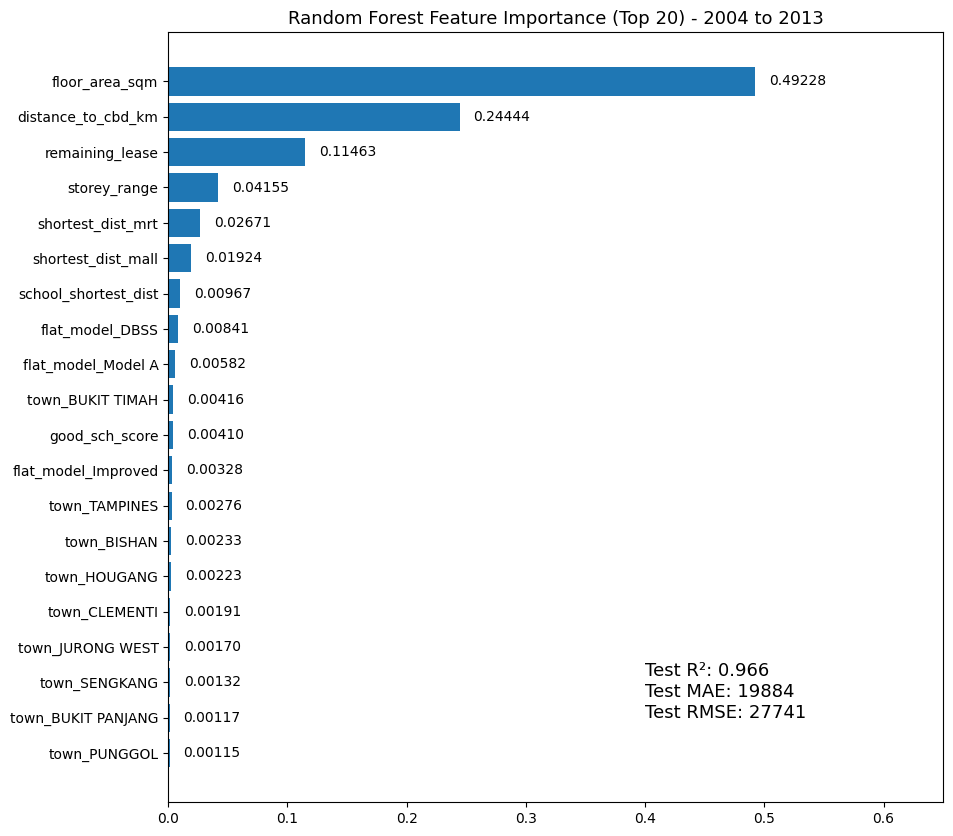

In [48]:
fig, ax = plt.subplots(figsize=(10,10))
rf_importance_graph = rf_importance.head(20)
graph = ax.barh(rf_importance_graph['Features'], rf_importance_graph['Coeff'])
plt.title('Random Forest Feature Importance (Top 20) - 2004 to 2013', size = 13)
plt.annotate(('Test R\u00b2: ' + str(round(rf_r2,3)) + '\nTest MAE: ' + str(round(rf_mae))+
             '\nTest RMSE: ' + str(round(rf_rmse))),
             xy=(0.4,18), fontsize = 13)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.bar_label(graph, fmt='%.5f', padding =10)
ax.set_xlim(right=0.65) 
ax.invert_yaxis()


plt.show()

#### Hyperparameter tuning using RandomizedSearchCV

In [49]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [50]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf1 = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf1, param_distributions = random_grid, n_iter = 2, cv = 3, verbose=2, random_state=100)
# Fit the random search model
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time= 3.0min
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time= 3.0min
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time= 3.0min


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=22.2min


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=22.3min


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=22.6min


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


{'n_estimators': 2000, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 110}


In [51]:
y_pred = rf_random.predict(X_test)

rf_random_r2 = r2_score(y_test, y_pred)
rf_random_mae = mean_absolute_error(y_test, y_pred)
rf_random_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('R^2 score =', rf_random_r2)
print('MAE:', rf_random_mae)
print('RMSE', rf_random_rmse)
    

R^2 score = 0.9641433724304962
MAE: 20321.08274031683
RMSE 28286.905279637187


In [52]:
rf_random_importance = pd.DataFrame(list(zip(rf_random.feature_names_in_, rf_random.best_estimator_.feature_importances_)),
                                    columns =['Features', 'Coeff'])
rf_random_importance = rf_random_importance.sort_values(by = 'Coeff', ascending = False).reset_index(drop =True)
rf_random_importance

,Features,Coeff
0,floor_area_sqm,0.498652
1,distance_to_cbd_km,0.246545
2,remaining_lease,0.111342
3,storey_range,0.041078
4,shortest_dist_mrt,0.025587
5,shortest_dist_mall,0.017870
6,flat_model_DBSS,0.008488
7,school_shortest_dist,0.008278
8,flat_model_Model A,0.005310
9,town_BUKIT TIMAH,0.004208


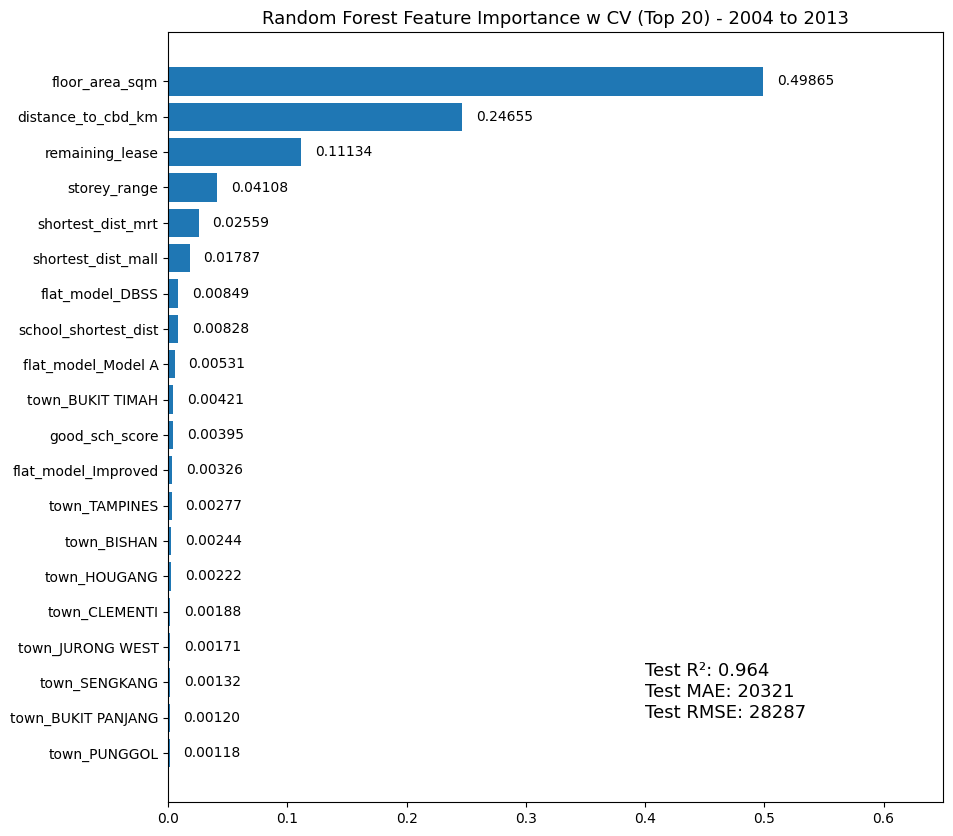

In [54]:
fig, ax = plt.subplots(figsize=(10,10))
rf_random_importance_graph = rf_random_importance.head(20)
graph = ax.barh(rf_random_importance_graph['Features'], rf_random_importance_graph['Coeff'])
plt.title('Random Forest Feature Importance w CV (Top 20) - 2004 to 2013', size = 13)
plt.annotate(('Test R\u00b2: ' + str(round(rf_random_r2,3)) + '\nTest MAE: ' + str(round(rf_random_mae))+
             '\nTest RMSE: ' + str(round(rf_random_rmse))),
             xy=(0.4,18), fontsize = 13)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.bar_label(graph, fmt='%.5f', padding =10)
ax.set_xlim(right=0.65) 
ax.invert_yaxis()


plt.show()

#### Out-of-Bag

In [55]:
oob_model = RandomForestRegressor(oob_score=True)
oob_r2, oob_mae, oob_rmse = model_performance(oob_model, X_train, X_test, y_train, y_test)

R^2 score = 0.9653093820333221
MAE: 19928.30708842188
RMSE 27823.17799889476


In [56]:
oob_model.oob_score_

0.9651035443667151

In [57]:
oob_importance = pd.DataFrame(list(zip(oob_model.feature_names_in_, oob_model.feature_importances_)), columns =['Features', 'Coeff'])
oob_importance = oob_importance.sort_values(by = 'Coeff', ascending = False).reset_index(drop =True)
oob_importance

,Features,Coeff
0,floor_area_sqm,0.491808
1,distance_to_cbd_km,0.244410
2,remaining_lease,0.115476
3,storey_range,0.042106
4,shortest_dist_mrt,0.026564
5,shortest_dist_mall,0.019143
6,school_shortest_dist,0.009692
7,flat_model_DBSS,0.008486
8,flat_model_Model A,0.005150
9,town_BUKIT TIMAH,0.004125


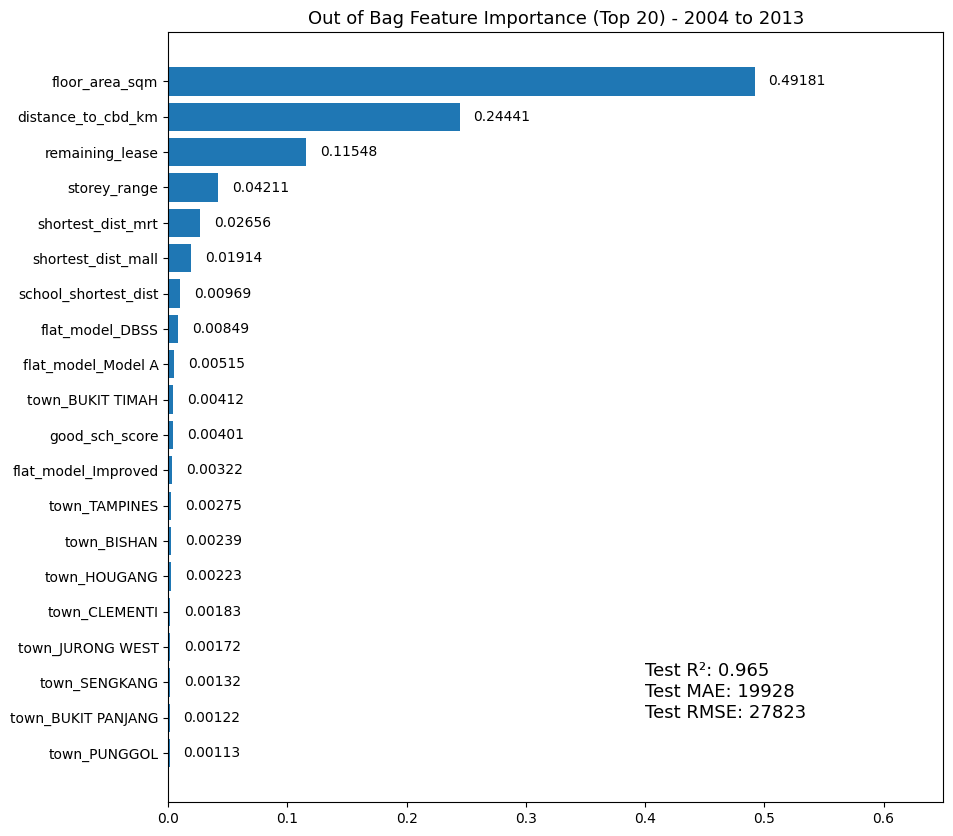

In [58]:
fig, ax = plt.subplots(figsize=(10,10))
oob_importance_graph = oob_importance.head(20)
graph = ax.barh(oob_importance_graph['Features'], oob_importance_graph['Coeff'])
plt.title('Out of Bag Feature Importance (Top 20) - 2004 to 2013', size = 13)
plt.annotate(('Test R\u00b2: ' + str(round(oob_r2,3)) + '\nTest MAE: ' + str(round(oob_mae))+
             '\nTest RMSE: ' + str(round(oob_rmse))),
             xy=(0.4,18), fontsize = 13)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.bar_label(graph, fmt='%.5f', padding =10)
ax.set_xlim(right=0.65) 
ax.invert_yaxis()


plt.show()

#### XGBoost

In [59]:
xgb = XGBRegressor()
xgb_r2, xgb_mae, xgb_rmse = model_performance(xgb, X_train, X_test, y_train, y_test)

R^2 score = 0.9491761891977503
MAE: 25397.90585402179
RMSE 33677.07226420258


In [60]:
xgb_importance = pd.DataFrame(list(zip(X_train.columns, xgb.feature_importances_)), columns =['Features', 'Coeff'])
xgb_importance = xgb_importance.sort_values(by = 'Coeff', ascending = False).reset_index(drop =True)
xgb_importance

,Features,Coeff
0,floor_area_sqm,0.159299
1,flat_model_DBSS,0.112538
2,flat_model_New Generation,0.100441
3,distance_to_cbd_km,0.099478
4,town_BUKIT TIMAH,0.057693
5,town_HOUGANG,0.044351
6,storey_range,0.035704
7,flat_model_Model A,0.032217
8,town_BISHAN,0.027820
9,town_TAMPINES,0.022350


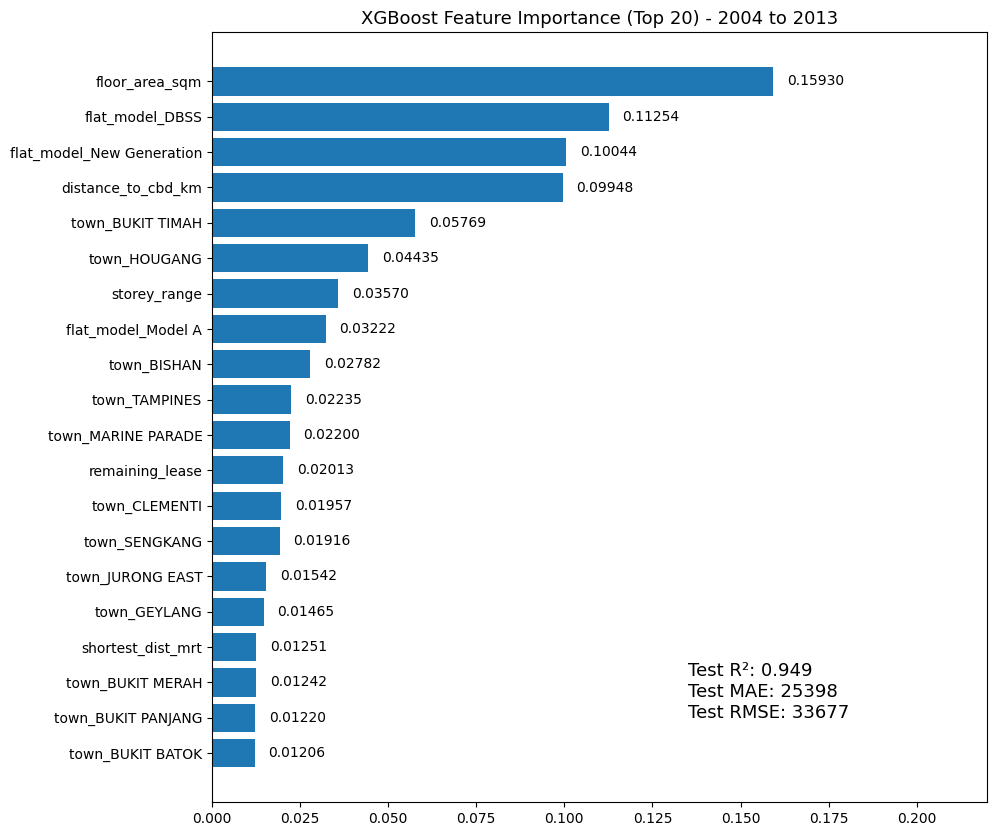

In [61]:
fig, ax = plt.subplots(figsize=(10,10))
xgb_importance_graph = xgb_importance.head(20)
graph = ax.barh(xgb_importance_graph['Features'], xgb_importance_graph['Coeff'])
plt.title('XGBoost Feature Importance (Top 20) - 2004 to 2013', size = 13)
plt.annotate(('Test R\u00b2: ' + str(round(xgb_r2,3)) + '\nTest MAE: ' + str(round(xgb_mae))+
             '\nTest RMSE: ' + str(round(xgb_rmse))),
             xy=(0.135,18), fontsize = 13)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.bar_label(graph, fmt='%.5f', padding =10)
ax.set_xlim(right=0.22) 
ax.invert_yaxis()


plt.show()

## Other Analysis

#### swap good_sch_score with good_sch_score_SAP_GEP

In [62]:
dropped_features_2 = ['mrt_count_within_1km','mall_count_within_1km',
                    'matured','good_sch_count_within_1km','flat_type','good_sch_score',
                    'year']

df_2 = data.drop(columns = dropped_features_2)

# Split target variable from dataset
y_2= df_2['adjusted_price']
X_2 = df_2.drop(columns='adjusted_price')

X2_train,X2_test,y2_train,y2_test=train_test_split(X_2,y_2,test_size=0.2,random_state=100)

# Scale dataset
continuous_features = ['floor_area_sqm', 'remaining_lease','shortest_dist_mrt',
                 'shortest_dist_mall', 'school_shortest_dist', 'distance_to_cbd_km']

scaler = StandardScaler()
X2_train_continuous = X2_train[continuous_features]
X2_train_continuous = scaler.fit_transform(X2_train_continuous)

X2_test_continuous = X2_test[continuous_features]
X2_test_continuous = scaler.transform(X2_test_continuous)

# Replace original continuous features with scaled ones in X

X2_train[continuous_features] = X2_train_continuous
X2_test[continuous_features] = X2_test_continuous

In [63]:
lr2 = LinearRegression()
lin_reg_2_r2, lin_reg_2_mae, lin_reg_2_rmse = model_performance(lr2, X2_train, X2_test, y2_train, y2_test)

R^2 score = 0.8472260882431587
MAE: 46075.79862804027
RMSE 58388.23071593198


In [64]:
lr_2_importance = pd.DataFrame(list(zip(lr2.feature_names_in_, lr2.coef_)), columns =['Features', 'Coeff'])
lr_2_importance = lr_2_importance.sort_values(by = 'Coeff', ascending = False).reset_index(drop =True)
lr_2_importance

,Features,Coeff
0,town_MARINE PARADE,180559.685439
1,town_BUKIT TIMAH,172260.109590
2,floor_area_sqm,101163.786164
3,flat_model_DBSS,96392.406467
4,town_BISHAN,66222.003068
5,remaining_lease,62379.280902
6,town_QUEENSTOWN,57554.300906
7,flat_model_Maisonette,37787.053763
8,town_BUKIT MERAH,34885.110961
9,town_CLEMENTI,29971.824165


In [65]:
X2_constant = sm.add_constant(X2_train)
lr_ols = sm.OLS(y2_train,X2_constant).fit()
print(lr_ols.summary())

                            OLS Regression Results                            
Dep. Variable:         adjusted_price   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                 2.124e+04
Date:                Sat, 01 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:32:07   Log-Likelihood:            -1.9693e+06
No. Observations:              158905   AIC:                         3.939e+06
Df Residuals:                  158862   BIC:                         3.939e+06
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [66]:
lr_2_importance['Coeff_ABS'] = np.abs(lr_2_importance['Coeff'])
lr_2_importance = lr_2_importance.sort_values('Coeff_ABS', ascending = False).reset_index(drop= True)
lr_2_importance['color'] = lr_2_importance['Coeff'].apply(lambda x: '#66ff8c' if x>0 else '#ff8c66')
lr_2_importance

,Features,Coeff,Coeff_ABS,color
0,town_MARINE PARADE,180559.685439,180559.685439,#66ff8c
1,town_BUKIT TIMAH,172260.109590,172260.109590,#66ff8c
2,floor_area_sqm,101163.786164,101163.786164,#66ff8c
3,flat_model_DBSS,96392.406467,96392.406467,#66ff8c
4,town_CHOA CHU KANG,-92325.547371,92325.547371,#ff8c66
5,town_SENGKANG,-87261.418942,87261.418942,#ff8c66
6,town_SEMBAWANG,-81955.302185,81955.302185,#ff8c66
7,town_BISHAN,66222.003068,66222.003068,#66ff8c
8,town_WOODLANDS,-65884.191569,65884.191569,#ff8c66
9,remaining_lease,62379.280902,62379.280902,#66ff8c


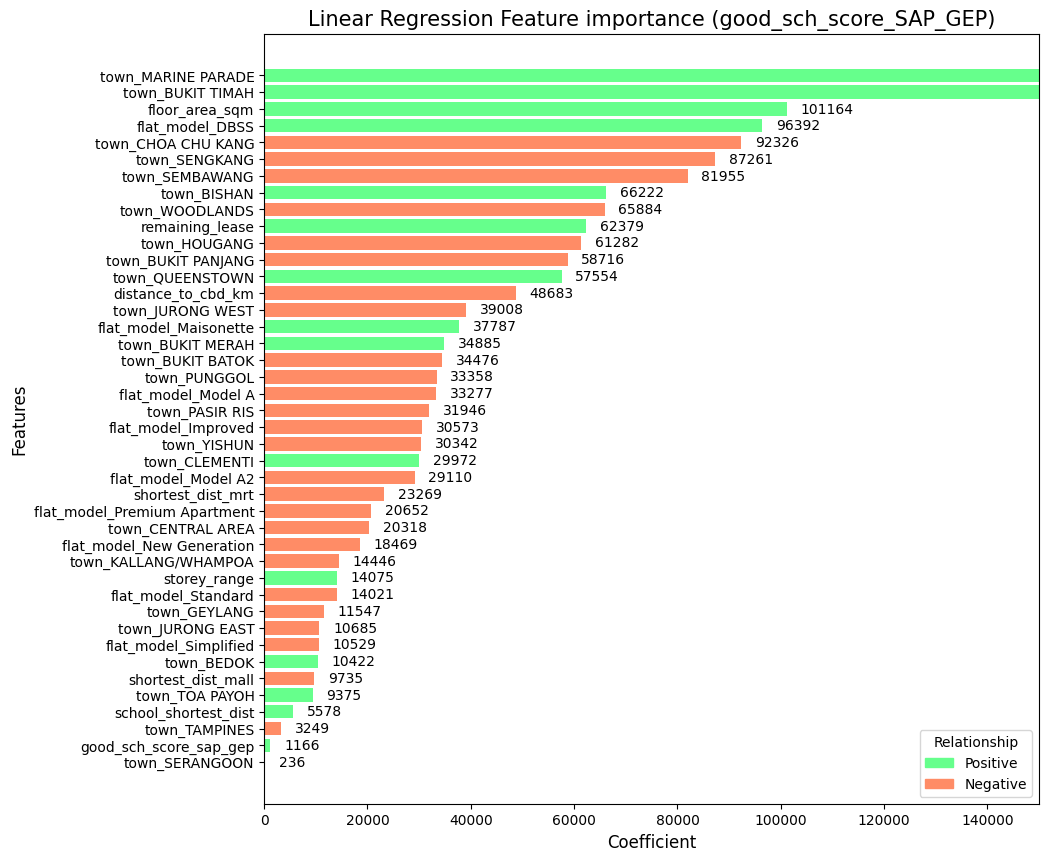

In [67]:
fig, ax = plt.subplots(figsize=(10,10))
graph = ax.barh(lr_2_importance['Features'], lr_2_importance['Coeff_ABS'],
                color=lr_2_importance['color'])


colors = {'Positive':'#66ff8c', 'Negative':'#ff8c66'}       
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels, title='Relationship',loc='lower right', fontsize ='10')

plt.title('Linear Regression Feature importance (good_sch_score_SAP_GEP)', size = 15)
plt.ylabel('Features', size = 12)
plt.xlabel('Coefficient', size = 12)
ax.bar_label(graph, fmt='%.0f', padding =10)
ax.set_xlim(right=150000) 
ax.invert_yaxis()

plt.show()

In [68]:
rf_2 = RandomForestRegressor()
rf_2_r2, rf_2_mae, rf_2_rmse = model_performance(rf_2, X2_train, X2_test, y2_train, y2_test)

rf_2_importance = pd.DataFrame(list(zip(rf_2.feature_names_in_, rf_2.feature_importances_)), columns =['Features', 'Coeff'])
rf_2_importance = rf_2_importance.sort_values(by = 'Coeff', ascending = False).reset_index(drop =True)
rf_2_importance

R^2 score = 0.9653071192270063
MAE: 19952.58229607919
RMSE 27824.085411906668


,Features,Coeff
0,floor_area_sqm,0.492608
1,distance_to_cbd_km,0.245238
2,remaining_lease,0.116224
3,storey_range,0.040441
4,shortest_dist_mrt,0.026909
5,shortest_dist_mall,0.019380
6,school_shortest_dist,0.009794
7,flat_model_DBSS,0.008442
8,flat_model_Model A,0.004627
9,town_BUKIT TIMAH,0.004054


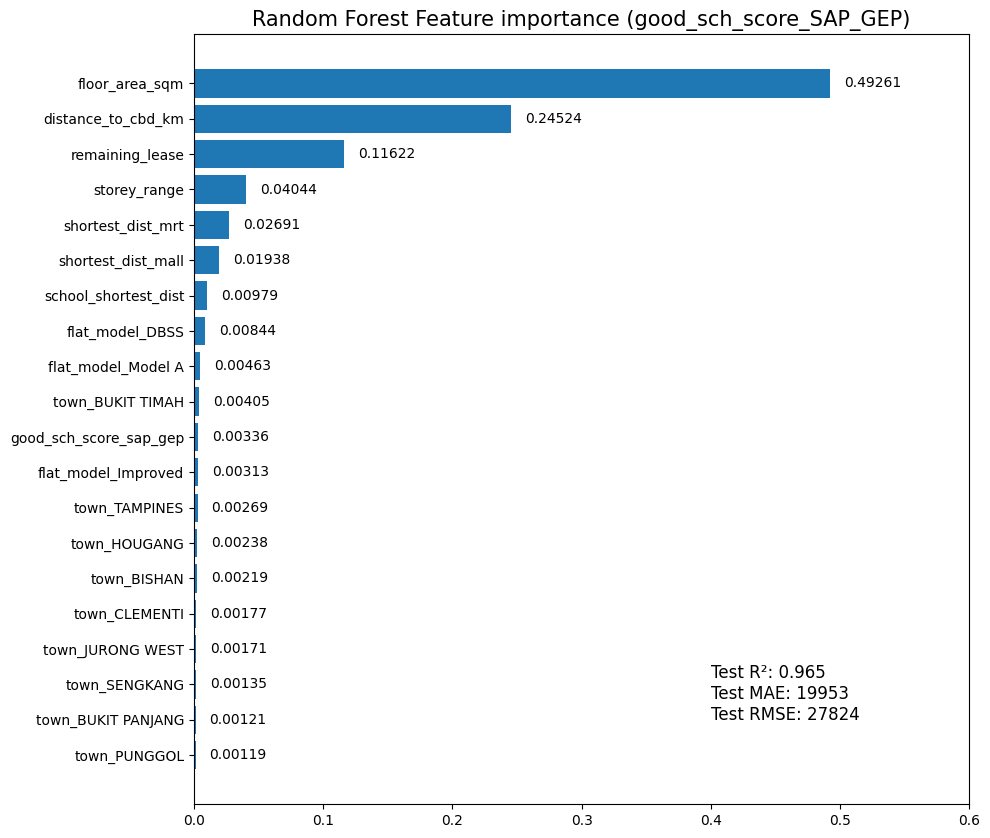

In [69]:
fig, ax = plt.subplots(figsize=(10,10))
rf_2_importance_graph = rf_2_importance.head(20)
graph = ax.barh(rf_2_importance_graph['Features'], rf_2_importance_graph['Coeff'])
plt.title('Random Forest Feature importance (good_sch_score_SAP_GEP)', size = 15)
plt.annotate(('Test R\u00b2: ' + str(round(rf_2_r2,3)) + '\nTest MAE: ' + str(round(rf_2_mae))+
             '\nTest RMSE: ' + str(round(rf_2_rmse))),
             xy=(0.4,18), fontsize = 12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.bar_label(graph, fmt='%.5f', padding =10)
ax.set_xlim(right=0.6) 
ax.invert_yaxis()


plt.show()

#### What if we remove floor_area_sqm, distance_to_cbd_km, and remaining_lease from the feature list?

In [70]:
dropped_features_2 = ['mrt_count_within_1km','mall_count_within_1km',
                    'matured','good_sch_count_within_1km','floor_area_sqm','flat_type',
                    'good_sch_score', 'year', 'distance_to_cbd_km', 'remaining_lease']

df_2 = data.drop(columns = dropped_features_2)

# Split target variable from dataset
y_2= df_2['adjusted_price']
X_2 = df_2.drop(columns='adjusted_price')

X2_train,X2_test,y2_train,y2_test=train_test_split(X_2,y_2,test_size=0.2,random_state=100)

# Scale dataset
continuous_features = ['shortest_dist_mrt',
                 'shortest_dist_mall', 'school_shortest_dist']

scaler = StandardScaler()
X2_train_continuous = X2_train[continuous_features]
X2_train_continuous = scaler.fit_transform(X2_train_continuous)

X2_test_continuous = X2_test[continuous_features]
X2_test_continuous = scaler.transform(X2_test_continuous)

# Replace original continuous features with scaled ones in X

X2_train[continuous_features] = X2_train_continuous
X2_test[continuous_features] = X2_test_continuous

In [71]:
lr3 = LinearRegression()
lin_reg_3_r2, lin_reg_3_mae, lin_reg_3_rmse = model_performance(lr3, X2_train, X2_test, y2_train, y2_test)

lr3_importance = pd.DataFrame(list(zip(lr3.feature_names_in_, lr3.coef_)), columns =['Features', 'Coeff'])
lr3_importance.sort_values(by = 'Coeff', ascending = False)

R^2 score = 0.5233543079167395
MAE: 77816.2274330052
RMSE 103133.21400034711


,Features,Coeff
10,town_BUKIT TIMAH,153404.169807
6,town_BISHAN,123376.876103
19,town_MARINE PARADE,104024.495813
8,town_BUKIT MERAH,78707.350945
32,flat_model_Maisonette,47211.498727
25,town_SERANGOON,32971.763746
22,town_QUEENSTOWN,25450.716091
0,storey_range,21952.839663
13,town_CLEMENTI,18151.593258
30,flat_model_DBSS,5754.040257


In [72]:
lr3_importance['Coeff_ABS'] = np.abs(lr3_importance['Coeff'])
lr3_importance = lr3_importance.sort_values('Coeff_ABS', ascending = False).reset_index(drop= True)
lr3_importance['color'] = lr3_importance['Coeff'].apply(lambda x: '#66ff8c' if x>0 else '#ff8c66')
lr3_importance

,Features,Coeff,Coeff_ABS,color
0,flat_model_New Generation,-319026.736254,319026.736254,#ff8c66
1,flat_model_Standard,-297167.604125,297167.604125,#ff8c66
2,flat_model_Simplified,-293915.434351,293915.434351,#ff8c66
3,flat_model_Model A2,-246349.403832,246349.403832,#ff8c66
4,flat_model_Model A,-210447.108667,210447.108667,#ff8c66
5,flat_model_Improved,-196350.518347,196350.518347,#ff8c66
6,town_BUKIT TIMAH,153404.169807,153404.169807,#66ff8c
7,flat_model_Premium Apartment,-150617.457941,150617.457941,#ff8c66
8,town_BISHAN,123376.876103,123376.876103,#66ff8c
9,town_SEMBAWANG,-118776.802209,118776.802209,#ff8c66


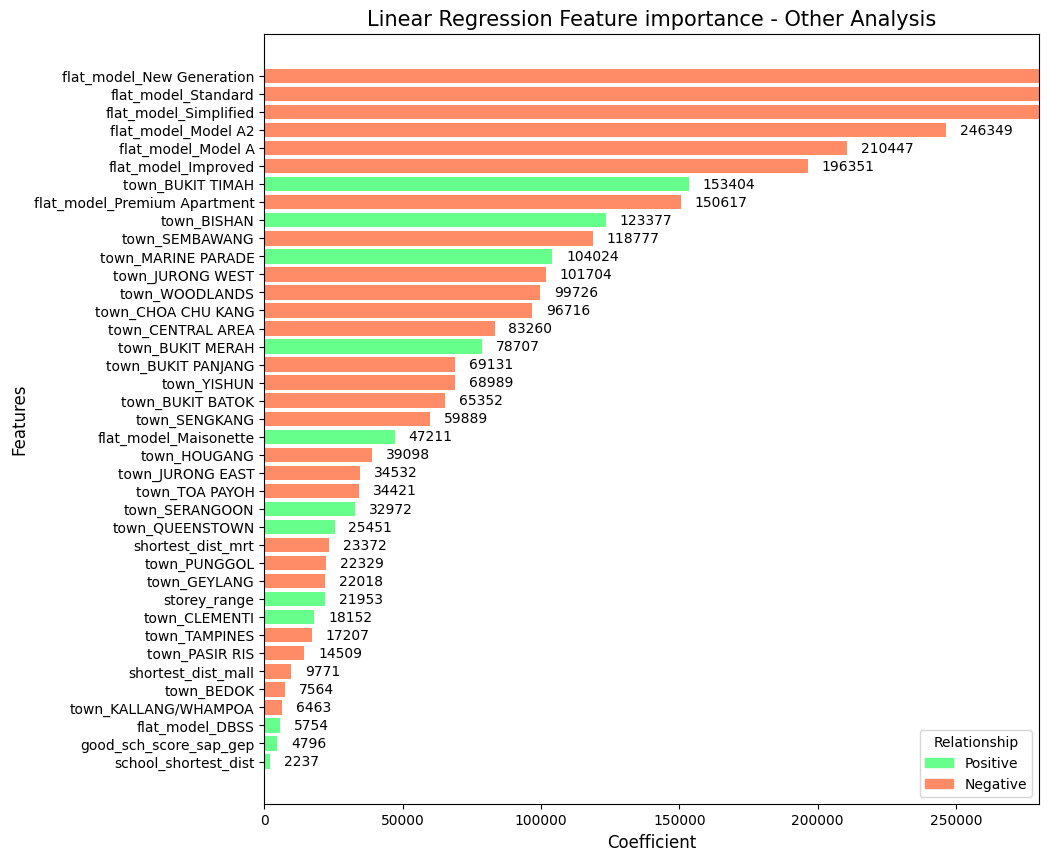

In [73]:
fig, ax = plt.subplots(figsize=(10,10))
graph = ax.barh(lr3_importance['Features'], lr3_importance['Coeff_ABS'],
                color=lr3_importance['color'])


colors = {'Positive':'#66ff8c', 'Negative':'#ff8c66'}       
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels, title='Relationship',loc='lower right', fontsize ='10')

plt.title('Linear Regression Feature importance - Other Analysis', size = 15)
plt.ylabel('Features', size = 12)
plt.xlabel('Coefficient', size = 12)
ax.bar_label(graph, fmt='%.0f', padding =10)
ax.set_xlim(right=280000) 
ax.invert_yaxis()

plt.show()

In [74]:
rf_3 = RandomForestRegressor()
rf_3_r2, rf_3_mae, rf_3_rmse = model_performance(rf_3, X2_train, X2_test, y2_train, y2_test)

rf_3_importance = pd.DataFrame(list(zip(rf_3.feature_names_in_, rf_3.feature_importances_)), columns =['Features', 'Coeff'])
rf_3_importance = rf_3_importance.sort_values(by = 'Coeff', ascending = False).reset_index(drop =True)
rf_3_importance

R^2 score = 0.8582515702654908
MAE: 40839.339467982754
RMSE 56241.88192386315


,Features,Coeff
0,storey_range,0.145928
1,shortest_dist_mrt,0.126329
2,shortest_dist_mall,0.097643
3,flat_model_Maisonette,0.094728
4,school_shortest_dist,0.090587
5,flat_model_New Generation,0.061890
6,town_BUKIT MERAH,0.031277
7,good_sch_score_sap_gep,0.029926
8,flat_model_DBSS,0.029466
9,town_BISHAN,0.024900


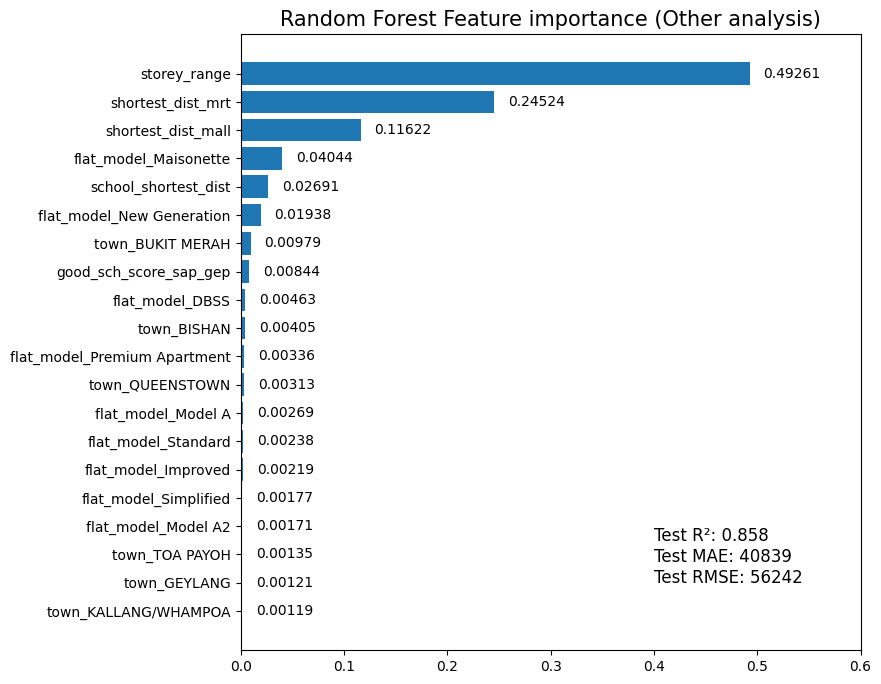

In [75]:
fig, ax = plt.subplots(figsize=(8,8))
rf_3_importance_graph = rf_3_importance.head(20)
graph = ax.barh(rf_3_importance_graph['Features'], rf_2_importance_graph['Coeff'])
plt.title('Random Forest Feature importance (Other analysis)', size = 15)
plt.annotate(('Test R\u00b2: ' + str(round(rf_3_r2,3)) + '\nTest MAE: ' + str(round(rf_3_mae))+
             '\nTest RMSE: ' + str(round(rf_3_rmse))),
             xy=(0.4,18), fontsize = 12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.bar_label(graph, fmt='%.5f', padding =10)
ax.set_xlim(right=0.6) 
ax.invert_yaxis()


plt.show()

SHAP values

In [76]:
import shap

ModuleNotFoundError: ignored

In [ ]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test.iloc[[16]])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[[16]])

In [ ]:
shap_values = explainer.shap_values(X_test.iloc[[1]])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[[1]])

Smallest Y Values

In [ ]:
y_test = y_test.reset_index()

In [ ]:
smallest = y_test['adjusted_price'].nsmallest(2).index

In [ ]:
smallest_1 = smallest[0]
shap_values = explainer.shap_values(X_test.iloc[[smallest_1]])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[[smallest_1]])

In [ ]:
smallest_2 = smallest[1]
shap_values = explainer.shap_values(X_test.iloc[[smallest_2]])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[[smallest_2]])

Median Y Values

In [ ]:
temp = y_test['adjusted_price']

# get the median value of the Series
median = temp.quantile(0.5)

# set the range around the median to include the two values closest to it
range_low = median - 0.5 * (temp.max() - temp.min()) / len(temp)
range_high = median + 0.5 * (temp.max() - temp.min()) / len(temp)

# use boolean indexing to get the indexes of the values that fall within the range around the median
median_indexes = temp[(temp >= range_low) & (temp <= range_high)].index

In [ ]:
median_1 = median_indexes[0]
shap_values = explainer.shap_values(X_test.iloc[[median_1]])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[[median_1]])

In [ ]:
median_2 = median_indexes[1]
shap_values = explainer.shap_values(X_test.iloc[[median_2]])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[[median_2]])

Largest Y Values

In [ ]:
largest = y_test['adjusted_price'].nlargest(2).index

In [ ]:
largest_1 = largest[0]
shap_values = explainer.shap_values(X_test.iloc[[largest_1]])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[[largest_1]])

In [ ]:
largest_2 = largest[1]
shap_values = explainer.shap_values(X_test.iloc[[largest_2]])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[[largest_2]])

In [ ]:
shap.summary_plot(shap_values, X, plot_type='bar')